<a href="https://colab.research.google.com/github/lblogan14/hands_on_notes/blob/master/Ch14_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)

#Recurrent Neurons
A recurrent neural network looks very much like a feedforward neural network, except it also has connections pointing backward. The simplest possible RNN, composed of just one neuron receiving inputs, producing an output, and sending that output back to itself. At each *time step t* (also called a *frame*), this *recurrent neuron* receives the inputs $x_{(t)}$ as well as its own output from the previous time step, $y_{(t–1)}$.

Each recurrent neuron has two sets of weights: one, $w_x$, for the inputs $x_{(t)}$ and the other, $w_y$ for
the outputs of the previous time step, $y_{(t–1)}$.

*Output of a single recurrent neuron for a single instance*:

$y_{(t)}=\phi(x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$

Compute a whole layer's output in a vectorized form for a whole mini-batch,

$Y_{(t)}=\phi(X_{(t)} \cdot W_{x}+Y_{(t-1)} \cdot W_y+b) \\
   \quad\,\, =\phi([X_{(t)}\quad Y_{(t-1)}] \cdot W + b)$
with $W^T = [W_x \quad W_y]^T$

* $Y_{(t)}$ is an $m × n_{neurons}$ matrix containing the layer’s outputs at time step $t$ for each instance in the mini-batch ($m$ is the number of instances in the mini-batch and $n_{neurons}$ is the number of neurons).
* $X_{(t)}$ is an $m × n_{inputs}$ matrix containing the inputs for all instances ($n_{inputs}$ is the number of input features).
* $W_x$ is an $n_{inputs} × n_{neurons}$ matrix containing the connection weights for the inputs of the current time step.
* $W_y$ is an $n_{neurons} × n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step.
* The weight matrices $W_x$ and $W_y$ are often concatenated into a single weight matrix $W$ of shape $(n_{inputs} + n_{neurons}) × n_{neurons}$
* $b$ is a vector of size $n_{neurons}$ containing each neuron’s bias term.

Notice that $Y_{(t)}$ is a function of $X_{(t)}$ and $Y_{(t–1)}$, which is a function of $X_{(t–1)}$ and $Y_{(t–2)}$, which is a function of $X_{(t–2)}$ and $Y_{(t–3)}$, and so on. This makes $Y_{(t)}$ a function of all the inputs since time $t = 0$ (that is, $X_{(0)}$, $X_{(1)}$, ..., $X_{(t)}$). At the first time step, $t = 0$, there are no previous outputs, so they are typically assumed to be all zeros.

##Memory Cells
Since the output of a recurrent neuron at time step $t$ is a function of all the inputs from previous time steps, you could say it has a form of *memory*.

*Memory cell* ia a part of a neural netowrk that preserves some state across times steps.

A single recurrent neuron, or a layer of recurrent neurons, is a *very basic cell*.

A cell's state at time step $t$, denoted $h_{(i)}$, is a function of some inputs at that time step and its state at the previous time step: $h_{(i)}=f(h_{(i-1)}, x_{(i)})$

Its output at time step $t$, denoted $y_{(i)}$, is also a function of the previous state and the current inputs.

##Input and Output Sequences
1. Sequence to Sequence - predict time series, such as stock prices
2. Sequence to Vector - sentiment anlysis
3. Vector to Sequence - predict the caption of an image
4. Delayed Sequence to Sequence - Encoder+Decoder, machine translation

#Basic RNNs in TensorFlow
Start with manual RNN without using TensorFlow RNN operations

In [0]:
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()

In [0]:
# Mini-batch:       instance 0, ins 1,   ins2,   ins3
X0_batch = np.array([[0,1,2], [3,4,5], [6,7,8], [9,0,1]]) # t = 0
X1_batch = np.array([[9,8,7], [0,0,0], [6,5,4], [3,2,1]]) # t = 1

with tf.Session() as sess:
  init.run()
  Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

This mini-batch contains four instances, each with an input sequence composed of exactly two inputs. At the end, Y0_val and Y1_val contain the outputs of the network at both time steps for all neurons and all instances in the mini-batch:

In [8]:
print(Y0_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.71978897 -0.9965762   0.9673924  -0.9998972 ]
 [ 0.99999785 -0.99898815 -0.9999989   0.9967762  -0.9999998 ]
 [ 1.         -1.         -1.         -0.9981893   0.9995087 ]]


In [9]:
print(Y1_val)

[[ 1.         -1.         -1.          0.40200275 -0.9999998 ]
 [-0.12210425  0.6280529   0.9671843  -0.9937122  -0.25839356]
 [ 0.9999982  -0.9999994  -0.9999975  -0.85943305 -0.9999879 ]
 [ 0.99928284 -0.99999803 -0.9999058   0.98579615 -0.9220575 ]]


##Static Unrolling Through Time
The **static_run()** function creates an unrolled RNN network by chaining cells.

In [0]:
n_inputs = 3
n_neurons = 5

reset_graph()

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)
#                                                ^cell       ^inputs   ^datatype of inputs

Y0, Y1 = output_seqs

The **static_rnn()** function returns two objects. The first is a Python list containing the output tensors for each time step. The second is a tensor containing the final states of the network.

In [0]:
init = tf.global_variables_initializer()

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]])
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]])

with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [13]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.65428466, -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.95425403, -0.75180787, -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.9994779 ],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.93039113,  0.81206834]],
      dtype=float32)

In [14]:
Y1_val

array([[ 0.999989  , -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968946, -0.59225935, -0.08968391],
       [ 0.99862397, -0.99715203, -0.03308637, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.3966063 , -0.83076054,  0.7967197 ]],
      dtype=float32)

###Packing sequences
For two time steps it is easy to write out inputs and outputs specifically, but extremely difficult if time steps become greater... say 100..
We need to write out code to simplify this process..

1. We need a single input placeholder of shape **[None, n_steps, n_inputs]** where the first dimension is the mini-batch size. Then it extracts the list of input sequences for each time step.

2. **X_seqs** is a Python list of **n_steps** tensors of shape **[None, n_inputs]**, where the first dimension is the mini-batch size. Use **transpose()** to swap the first two dimensions.

3. Use **unstack()** to extract a Python list of tensors along the first dimension (i.e., one tensor per time step)

4. Then, use **stack()** to merge all the output tensors into a single tensor and also swap the first two dimensions to get a final **output** tensor of shape **[None, n_steps, n_neurons]**

In [26]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()
# Step 1
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
#            Step3       Step 2
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)

# Step 4
outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()

X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
X_batch.shape

(4, 2, 3)

In [0]:
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

we get a single **outputs_val** tensor for all instances, all time steps, and all neurons:

In [28]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.94288    -0.999887    0.9405581   0.9999984  -0.9999998 ]]

 [[-0.80015343 -0.9921827   0.78177965  0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999814  -0.9999831 ]
  [-0.9165386  -0.9945605   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927367  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.7319198   0.7827872   0.9525681  -0.978177  ]]]


In [32]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])

[[-0.94288    -0.999887    0.9405581   0.9999984  -0.9999998 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945605   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.7319198   0.7827872   0.9525681  -0.978177  ]]


This approach still builds a graph containing one cell per time step. To write a program with using loops, use the **dynamic_rnn()** function.

##Dynamic Unrolling Through Time
The **dynamic_rnn()** function uses a **while_loop()** operation to run over the cell the appropriate number of times, and you can set **swap_memory=True** if you want it to swap the GPU’s memory to the CPU’s memory during backpropagation to avoid OOM errors.

it also accepts a single tensor for all inputs at every time step (shape **[None, n_steps, n_inputs]**) and it outputs a single tensor for all outputs at every time step (shape **[None, n_steps, n_neurons]**); there is no need to stack, unstack, or transpose.

In [2]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [0]:
X_batch = np.array([
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
])

with tf.Session() as sess:
  init.run()
  outputs_val = outputs.eval(feed_dict={X: X_batch})

In [4]:
print(outputs_val)

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.9999959   0.9999958   0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071444  0.999985    0.25192663]
  [-0.7081804  -0.07723374 -0.8522789   0.5845349  -0.78780943]]

 [[-0.9999826   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993955   0.99840957  0.83422637  0.99999976 -0.47325206]]

 [[ 0.8788859   0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.91345143  0.36009565  0.7624866   0.99817705  0.80142   ]]]


##Handling Variable Length Input Sequences
To handle variable length of input sequences, set a **sequence_length** parameter, which must be a 1D tensor indicating the length of the input sequence for each instance,

In [0]:
n_steps = 2
n_inputs = 3
n_neurons = 5

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

In [0]:
seq_length = tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [0]:
init = tf.global_variables_initializer()

In [0]:
X_batch = np.array([
        # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])
seq_length_batch = np.array([2, 1, 2, 2])
# ^indicates the length of each instance

In [0]:
with tf.Session() as sess:
  init.run()
  outputs_val, states_val = sess.run(
      [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [10]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.95672596  0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.9999998   0.8967998   0.9986295   0.9647514   0.93661994]
  [-0.9999526   0.96819544  0.9600285   0.98706263  0.85459226]]

 [[-0.96435434  0.995016   -0.36150697  0.9983377   0.99949706]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [11]:
print(states_val)

[[-1.          0.95672596  0.99831694  0.99970174  0.96518576]
 [-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
 [-0.9999526   0.96819544  0.9600285   0.98706263  0.85459226]
 [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]


##Handling Variables-Length Output Sequences
need to define a special output called an *end-of-sequence token* (EOS TOKEN). Any output past the EOS should be ignored.

#Training RNNs
To train an RNN, the trick is to unroll it through time and then simply use regular backpropagation, which is called *backpropagation through time* (BPTT)

##Training a Sequence Classifier
For MNIST, We will treat each image as a sequence of 28 rows of 28 pixels each (since each MNIST image is 28 × 28 pixels). We will use cells of 150 recurrent neurons, plus a fully connected layer containing 10 neurons (one per class) connected to the output of the last time step, followed by a softmax layer

In [2]:
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


load the MNIST data and reshape the test data to **[batch_size, n_steps,n_inputs]** as is expected by the network.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


reshape each training batch before feeding it to the network.

In [4]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    for iteration in range(mnist.train.num_examples // batch_size):
      X_batch, y_batch = mnist.train.next_batch(batch_size)
      X_batch = X_batch.reshape((-1, n_steps, n_inputs))
      
      sess.run(training_op, feed_dict={X: X_batch, y:y_batch})
      
    acc_train = accuracy.eval(feed_dict={X: X_batch, y:y_batch})
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print(epoch, 'Train accuracy:', acc_train, 'Test accuracy:', acc_test)

0 Train accuracy: 0.93333334 Test accuracy: 0.9311
1 Train accuracy: 0.96666664 Test accuracy: 0.9522
2 Train accuracy: 0.97333336 Test accuracy: 0.9583
3 Train accuracy: 0.96666664 Test accuracy: 0.966
4 Train accuracy: 0.97333336 Test accuracy: 0.9708
5 Train accuracy: 0.98 Test accuracy: 0.9712
6 Train accuracy: 0.96666664 Test accuracy: 0.9715
7 Train accuracy: 0.97333336 Test accuracy: 0.972
8 Train accuracy: 0.93333334 Test accuracy: 0.967
9 Train accuracy: 0.97333336 Test accuracy: 0.9684
10 Train accuracy: 0.9866667 Test accuracy: 0.9727
11 Train accuracy: 0.98 Test accuracy: 0.9758
12 Train accuracy: 0.96666664 Test accuracy: 0.9721
13 Train accuracy: 0.9866667 Test accuracy: 0.9719
14 Train accuracy: 0.96 Test accuracy: 0.9654
15 Train accuracy: 0.9866667 Test accuracy: 0.9695
16 Train accuracy: 0.98 Test accuracy: 0.9737
17 Train accuracy: 0.98 Test accuracy: 0.9708
18 Train accuracy: 0.98 Test accuracy: 0.9723
19 Train accuracy: 0.98 Test accuracy: 0.9782
20 Train accuracy:

You can specify an initializer for the RNN by wrapping its construction code in a variable scope (e.g., use **variable_scope("rnn", initializer=variance_scaling_initializer())** to use He initialization).

###Multi-Layer RNN

In [0]:
reset_graph()

n_steps = 28
n_inputs = 28
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

In [0]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [0]:
states_concat = tf.concat(axis=1, values=states)

logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [11]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

0 Train accuracy: 0.9266667 Test accuracy: 0.9406
1 Train accuracy: 0.99333334 Test accuracy: 0.9669
2 Train accuracy: 0.94666666 Test accuracy: 0.9648
3 Train accuracy: 0.98 Test accuracy: 0.974
4 Train accuracy: 0.97333336 Test accuracy: 0.973
5 Train accuracy: 1.0 Test accuracy: 0.9753
6 Train accuracy: 0.96666664 Test accuracy: 0.9772
7 Train accuracy: 0.99333334 Test accuracy: 0.9785
8 Train accuracy: 1.0 Test accuracy: 0.9799
9 Train accuracy: 0.96666664 Test accuracy: 0.9765


##Training to Predict Time Series
train an RNN to predict the next value in a generated time series.

In [0]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
  return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
  t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps*resolution)
  Ts = t0 + np.arange(0., n_steps+1) * resolution
  ys = time_series(Ts)
  return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

Text(0.5,0,'Time')

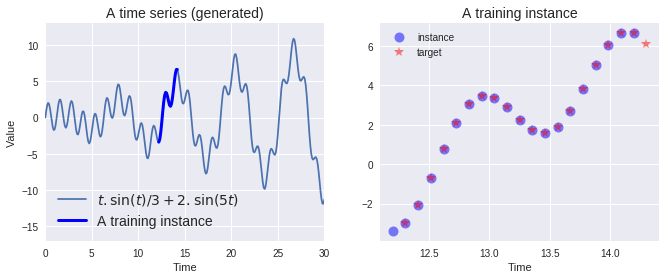

In [21]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2+resolution*(n_steps+1), n_steps+1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, alpha=0.5, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "r*", markersize=10, alpha=0.5, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

Each training instance is a randomly
selected sequence of 20 consecutive values from the time series, and the target
sequence is the same as the input sequence, except it is shifted by one time step into
the future

In [22]:
X_batch, y_batch = next_batch(1, n_steps)
np.c_[X_batch[0], y_batch[0]]

array([[ 1.38452097,  2.05081182],
       [ 2.05081182,  2.29742291],
       [ 2.29742291,  2.0465599 ],
       [ 2.0465599 ,  1.34009916],
       [ 1.34009916,  0.32948704],
       [ 0.32948704, -0.76115235],
       [-0.76115235, -1.68967022],
       [-1.68967022, -2.25492776],
       [-2.25492776, -2.34576159],
       [-2.34576159, -1.96789418],
       [-1.96789418, -1.24220428],
       [-1.24220428, -0.37478448],
       [-0.37478448,  0.39387907],
       [ 0.39387907,  0.84815766],
       [ 0.84815766,  0.85045064],
       [ 0.85045064,  0.3752526 ],
       [ 0.3752526 , -0.48422846],
       [-0.48422846, -1.53852738],
       [-1.53852738, -2.54795941],
       [-2.54795941, -3.28097239]])

RNN contains 100 recurrent neurons and is unrolled over 20 time steps since each training instance will be 20 inputs long. Each input will contain only one feature (the value at that time). The targets are also sequences of 20 inputs, each containing a single value.

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

###Using an OutputProjectionWrapper
At each time step we now have an output vector of size 100. But what we actually want is a single output value at each time step. The simplest solution is to wrap the cell in an **OutputProjectionWrapper**.

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [0]:
cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
                                             output_size=n_outputs)

In [0]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [0]:
learning_rate = 0.001

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [33]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
  init.run()
  for iteration in range(n_iterations):
    X_batch, y_batch = next_batch(batch_size, n_steps)
    sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if iteration % 100 == 0:
      mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
      print(iteration, '\tMSE:', mse)
  
  saver.save(sess, './my_time_series_model')

0 	MSE: 11.967254
100 	MSE: 0.52263814
200 	MSE: 0.1504189
300 	MSE: 0.073602825
400 	MSE: 0.061815273
500 	MSE: 0.058881626
600 	MSE: 0.05312271
700 	MSE: 0.048359204
800 	MSE: 0.04979287
900 	MSE: 0.047359522
1000 	MSE: 0.04744968
1100 	MSE: 0.04833125
1200 	MSE: 0.042004373
1300 	MSE: 0.04930782
1400 	MSE: 0.04192228


In [34]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_time_series_model


In [35]:
y_pred

array([[[-3.4087536],
        [-2.4560106],
        [-1.1175244],
        [ 0.7889128],
        [ 2.1429348],
        [ 3.1170843],
        [ 3.464506 ],
        [ 3.2982976],
        [ 2.8940275],
        [ 2.237141 ],
        [ 1.6398021],
        [ 1.5256968],
        [ 1.9079566],
        [ 2.7027197],
        [ 3.8846385],
        [ 5.1268897],
        [ 6.1268754],
        [ 6.6273956],
        [ 6.605406 ],
        [ 6.057085 ]]], dtype=float32)

Text(0.5,0,'Time')

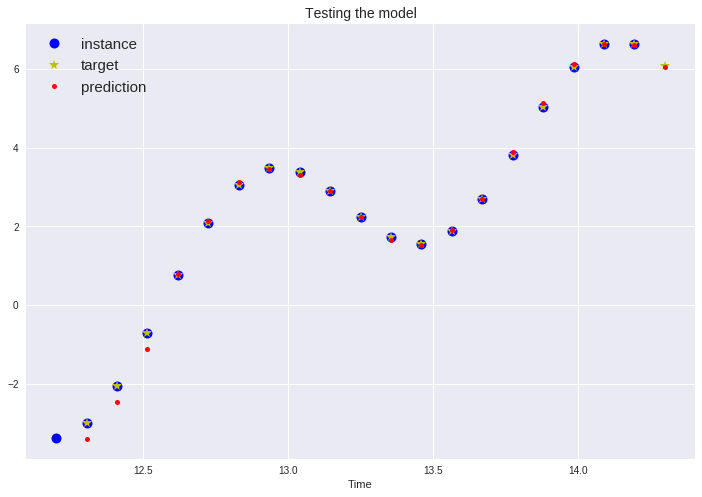

In [41]:
plt.figure(figsize=(12, 8))
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left", fontsize=15)
plt.xlabel("Time")

###Without using an OutputProjectionWrapper
There is a trickier but *more efficient* solution: you can reshape the RNN outputs from **[batch_size, n_steps, n_neurons]** to **[batch_size * n_steps, n_neurons]**, then apply a *single fully connected layer* with the appropriate output size (in our case just 1), which will result in an output tensor of shape **[batch_size * n_steps, n_outputs]**, and then reshape this tensor to **[batch_size, n_steps, n_outputs]**.

In [0]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [0]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

In [0]:
n_outputs = 1
learning_rate = 0.001

In [0]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

In [0]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [73]:
n_iterations = 1500
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model/")

0 	MSE: 13.907028
100 	MSE: 0.50597644
200 	MSE: 0.1971952
300 	MSE: 0.10069896
400 	MSE: 0.066519484
500 	MSE: 0.062382575
600 	MSE: 0.055503424
700 	MSE: 0.050072886
800 	MSE: 0.0507705
900 	MSE: 0.04879052
1000 	MSE: 0.0486596
1100 	MSE: 0.050334293
1200 	MSE: 0.04186243
1300 	MSE: 0.04934902
1400 	MSE: 0.043026894


In [74]:
y_pred

array([[[-3.4321263 ],
        [-2.466367  ],
        [-1.1100639 ],
        [ 0.64086646],
        [ 2.1177657 ],
        [ 3.0619044 ],
        [ 3.5102527 ],
        [ 3.3746624 ],
        [ 2.8048453 ],
        [ 2.1530163 ],
        [ 1.6899419 ],
        [ 1.5366589 ],
        [ 1.8864701 ],
        [ 2.7230186 ],
        [ 3.8647237 ],
        [ 5.1048574 ],
        [ 6.0946007 ],
        [ 6.6182065 ],
        [ 6.584768  ],
        [ 6.006245  ]]], dtype=float32)

Text(0.5,0,'Time')

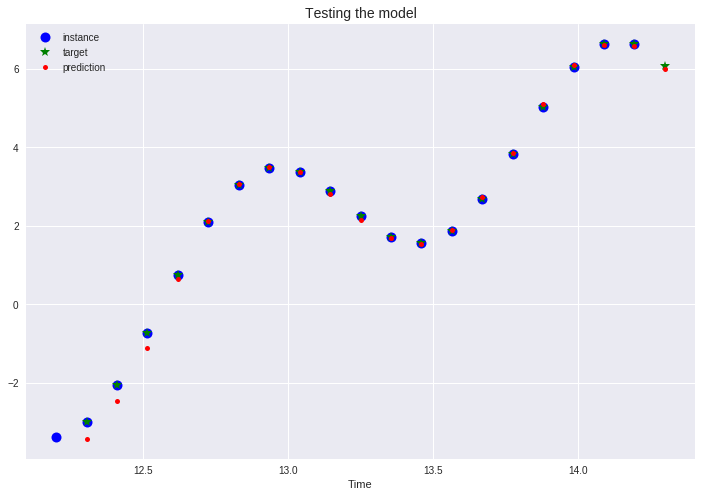

In [75]:
plt.figure(figsize=(12, 8))
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "g*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

##Creative RNN
Now that we have a model that can predict the future, we can use it to generate some creative sequences.

provide it a seed sequence containing **n_steps** values (e.g., full of zeros), use the model to predict the next value, append this predicted value to the sequence, feed the last **n_steps** values to the model to predict the next value, and so on.

In [76]:
with tf.Session() as sess:
  saver.restore(sess, './my_time_series_model/')
  
  sequence = [0.] * n_steps
  for iteration in range(300):
    X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
    y_pred = sess.run(outputs, feed_dict={X: X_batch})
    sequence.append(y_pred[0, -1, 0])
    # output tensor shape=[batch_size, n_steps, n_outputs]

INFO:tensorflow:Restoring parameters from ./my_time_series_model/


Text(0,0.5,'Value')

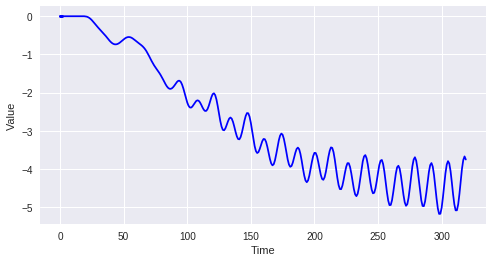

In [77]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

In [79]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./my_time_series_model


Text(0.5,0,'Time')

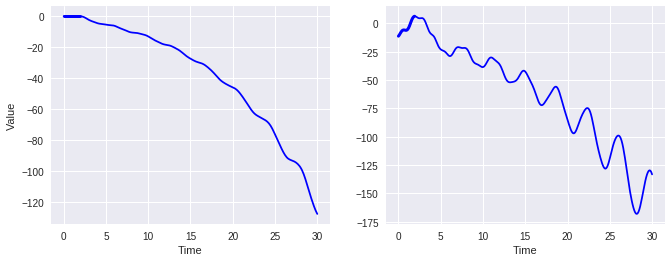

In [80]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")

#Deep RNNs
stack multiple layers of cells...

To implement a deep RNN in TensorFlow, you can create several cells and stack them into a **MultiRNNCell**.

In [0]:
reset_graph()

n_inputs = 2
n_steps = 5

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

In [0]:
n_neurons = 100
n_layers = 3

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
          for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

init = tf.global_variables_initializer()

In [0]:
X_batch = np.random.rand(2, n_steps, n_inputs)

In [0]:
with tf.Session() as sess:
  init.run()
  outputs_val, state_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [86]:
outputs_val.shape

(2, 5, 100)

The **states** variable is a tuple containing one tensor per layer, each representing the final state of that layer’s cell (with shape **[batch_size, n_neurons])**. 

If you set **state_is_tuple=False** when creating the **MultiRNNCell**, then states becomes a single tensor containing the states from every layer, concatenated along the column axis (i.e., its shape is **[batch_size, n_layers * n_neurons])**.

##Distributing a Deep RNN across Mulitple GPUs
Do **NOT** ever try the following,

In [0]:
with tf.device("/gpu:0"):  # BAD! This is ignored.
    layer1 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

with tf.device("/gpu:1"):  # BAD! Ignored again.
    layer2 = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

The correct way to distribute RNN across multiple GPUs is to use a **DeviceCellWrapper**,

In [0]:
class DeviceCellWrapper(tf.contrib.rnn.RNNCell):
  def __init__(self, device, cell):
    self._device = device
    self._cell = cell
    
  @property
  def state_size(self):
    return self._cell.state_size
  
  @property
  def output_size(self):
    return self._cell.output_size
  
  def __call__(self, inputs, state, scope=None):
    with tf.device(self._device):
      return self._cell(inputs, state, scope)

This wrapper simply proxies every method call to another cell, except it wraps the **\__call__()** function within a device block.

In [0]:
reset_graph()

n_inputs = 5
n_steps = 20
n_neurons = 100

X = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs])

In [0]:
devices = ["/cpu:0", "/cpu:0", "/cpu:0"] # replace with ["/gpu:0", "/gpu:1", "/gpu:2"] if you have 3 GPUs
cells = [DeviceCellWrapper(dev,tf.contrib.rnn.BasicRNNCell(num_units=n_neurons))
         for dev in devices]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

Alternatively, since TensorFlow 1.1, you can use the **tf.contrib.rnn.DeviceWrapper** class (alias **tf.nn.rnn_cell.DeviceWrapper** since TF 1.2).

In [93]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(sess.run(outputs, feed_dict={X: np.random.rand(2, n_steps, n_inputs)}))

[[[-3.2902010e-02  1.1701923e-01 -4.5899246e-02 ...  3.8447704e-02
   -5.2490000e-02  5.8043696e-02]
  [ 3.5428837e-02 -7.4261218e-02 -6.4237513e-02 ... -2.4575704e-01
   -1.7762682e-01 -3.2653331e-03]
  [ 2.5972652e-01  1.4460522e-01  3.2931221e-01 ...  3.3882204e-01
    5.9885412e-02 -8.3144858e-02]
  ...
  [ 1.1804418e-01 -2.4166366e-01 -8.2779825e-01 ... -1.8578218e-01
    1.8968213e-01 -1.3526212e-01]
  [ 2.8783119e-01  3.9295399e-01 -3.1523648e-01 ... -7.8560874e-02
    4.3272454e-01 -6.6182777e-02]
  [ 7.4978012e-01  6.1105335e-01 -3.0168572e-01 ...  1.9565013e-01
   -1.6245714e-01 -5.2396566e-02]]

 [[-6.6802777e-02  7.3557667e-02 -2.9027537e-02 ... -7.7996828e-02
   -3.6577322e-02 -4.6675194e-02]
  [ 1.7154643e-01  4.2841923e-03  2.1881519e-03 ...  3.6853828e-02
   -8.1324145e-02  9.0100162e-02]
  [ 3.4563683e-02 -9.5752515e-02  1.5945031e-01 ...  1.6302212e-01
   -6.8304457e-02  1.0799057e-01]
  ...
  [ 1.9641407e-01 -2.1523033e-01 -5.8253795e-01 ...  3.0253306e-01
    5.4786

##Applying Dropout
If you build a very deep RNN, it may end up overfitting the training set. To prevent that, a common technique is to apply dropout.

recall that dropout should be applied only during training

In [0]:
reset_graph()

n_inputs = 1
n_neurons = 100
n_layers = 3
n_steps = 20
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

Note: the **input_keep_prob** parameter can be a placeholder, making it possible to set it to any value you want during training, and to 1.0 during testing (effectively turning dropout off)

In [0]:
keep_prob = tf.placeholder_with_default(1.0, shape=())
cells = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
              for cell in cells]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(cells_drop)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

In [0]:
learning_rate = 0.01

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [98]:
n_iterations = 1500
batch_size = 50
train_keep_prob = 0.5

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        _, mse = sess.run([training_op, loss],
                          feed_dict={X: X_batch, y: y_batch,
                                     keep_prob: train_keep_prob})
        if iteration % 100 == 0:
            print(iteration, "Training MSE:", mse)
    
    saver.save(sess, "./my_dropout_time_series_model")

0 Training MSE: 16.386942
100 Training MSE: 4.216745
200 Training MSE: 3.7074125
300 Training MSE: 4.000473
400 Training MSE: 2.5830722
500 Training MSE: 3.438565
600 Training MSE: 3.2967608
700 Training MSE: 3.544313
800 Training MSE: 4.1937485
900 Training MSE: 3.8550723
1000 Training MSE: 3.999891
1100 Training MSE: 3.5475717
1200 Training MSE: 3.168245
1300 Training MSE: 2.8991961
1400 Training MSE: 3.8252215


In [99]:
with tf.Session() as sess:
    saver.restore(sess, "./my_dropout_time_series_model")

    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./my_dropout_time_series_model


Text(0.5,0,'Time')

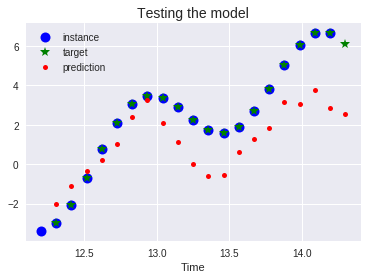

In [100]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "g*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

In this case, Dropout did not help...

#LSTM Cell
The Long Short-Term Memory (LSTM) cell performs much better and converges faster, and detects long-term dependencies in the data.

![](https://www.oreilly.com/library/view/neural-networks-and/9781492037354/assets/mlst_1413.png)

The outer shell of the LSTM cell looks like a regular cell, except that its state is split in two vectors: $h_{(t)}$ and $c_{(t)}$ ("h" stands for "hidden" and "c" stands for "cell"). $h_{(t)}$ is for the short-term state and $c_{(t)}$ is for the long-term state.

The current input vector $x_{(t)}$ and the previous short-term state $h_{(t–1)}$ are fed to four different fully connected layers.
* Main layer, $g_{(t)}$, analyzes $x_{(t)}$ and $h_{(t-1)}$, and then its output is partially stored in the long-term state.
* Three other layrs are *gate controllers*, using logistic activation whose outputs range from 0 to 1 performing element-wise multiplication. If outputs 0s, they close the gate, if outputs 1s, they open it.
 * Forget gate, (controlled by $f_{(t)}$), controls which parts of the long-term state should be erased.
 * Input gate, (controlled by $i_{(t)})$) controls which parts of $g_{(t)}$ should be added to the long-term state
 * Output gate, (controlled by $o_{(t)}$) controlls which parts of the long-term state should be read and output at this time step (both to $h_{(t)}$ and $y_{(t)}$)

*LSTM computations*

$$i_{(t)}=\sigma(W_{xi}^T \cdot x_{(t)}+W_{hi}^T \cdot h_{(t-1)}+b_i)$$

$$f_{(t)}=\sigma(W_{xf}^T \cdot x_{(t)}+W_{hf}^T \cdot h_{(t-1)}+b_f)$$

$$o_{(t)}=\sigma(W_{xo}^T \cdot x_{(t)}+W_{ho}^T \cdot h_{(t-1)}+b_o)$$

$$g_{(t)}=\tanh(W_{xi}^T \cdot x_{(t)}+W_{hi}^T \cdot h_{(t-1)}+b_g)$$

$$c_{(t)}= f_{(t)} \otimes c_{(t-1)}+i_{(t)} \otimes g_{(t)}$$

$$y_{(t)}=h_{(t)}=o_{(t)} \otimes \tanh(c_{(t)})$$

* $W_{xi}, W_{xf}, W_{xo}, W_{xg}$ are the weight matrics of each of the four layers for their connection to the input vector $x_{(t)}$
* $W_{hi}, W_{hf}, W_{ho}, W_{hg}$ are the weight matrics of each of the four layers for their connection to the previous short-term state $h_{(t-1)}$
* $b_i, b_f. b_o, b_g$ are the bias terms for each of the four layers. Note that TensorFlow initializes $b_f$ to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training.

In [101]:
reset_graph()

lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)

Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').


In [0]:
n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

#stack lstm cells
lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
top_layer_h_state = states[-1][1]

logits = tf.layers.dense(top_layer_h_state, n_outputs, name="softmax")
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [103]:
states

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [104]:
top_layer_h_state

<tf.Tensor 'rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [105]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((batch_size, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("Epoch", epoch, "Train accuracy =", acc_train, "Test accuracy =", acc_test)

Epoch 0 Train accuracy = 0.9533333 Test accuracy = 0.9551
Epoch 1 Train accuracy = 0.98 Test accuracy = 0.9674
Epoch 2 Train accuracy = 0.9866667 Test accuracy = 0.9739
Epoch 3 Train accuracy = 0.99333334 Test accuracy = 0.9812
Epoch 4 Train accuracy = 0.97333336 Test accuracy = 0.9843
Epoch 5 Train accuracy = 0.98 Test accuracy = 0.9832
Epoch 6 Train accuracy = 0.99333334 Test accuracy = 0.9845
Epoch 7 Train accuracy = 0.99333334 Test accuracy = 0.9876
Epoch 8 Train accuracy = 1.0 Test accuracy = 0.9885
Epoch 9 Train accuracy = 1.0 Test accuracy = 0.9861


##Peephole Connections
It may be a good idea to give them a bit more context by letting them peek at the long-term state as well.

Peephole connections: the previous long-term state $c_{(t–1)}$ is added as an input to the controllers of the forget gate and the input gate, and the current long=term state $c_{(t)}$ is added as input to the controller of the output gate.

In [0]:
lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)

#GRU Cell
Gated Recurrent Unit cell, simplified version of LSTM cell.
![](https://www.oreilly.com/library/view/neural-networks-and/9781492037354/assets/mlst_1414.png)

* Both state vectors are merged into a single vector $h_{(t)}$
* A single gate controller controls both the forget gate and the input gate. If the gate controller outputs a 1, the input gate is open and the forget gate is closed. If it outputs a 0, the opposite happens. In other words, whenever a memory must be stored, the location where it will be stored is erased first. This is actually a frequent variant to the LSTM cell in and of itself.
* There is no output gate; the full state vector is output at every time step. However, there is a new gate controller that controls which part of the previous state will be shown to the main layer.

*GRU computations*

$z_{(t)}=\sigma(W_{xz}^T\cdot x_{(t)}+W_{hz}^T\cdot h_{(t-1)})$

$r_{(t)}=\sigma(W_{xr}^T\cdot x_{(t)}+W_{hr}^T\cdot h_{(t-1)})$

$g_{(t)}=\tanh(W_{xg}^T\cdot x_{(t)}+W_{hg}^T\cdot (r_{(t)}\otimes h_{(t-1)}))$

$h_{(t)}=(1-z_{(t)})\otimes \tanh(W_{xg}^T\cdot h_{(t-1)}+z_{(t)}\otimes g_{(t)})$

In [0]:
gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)

#Natural Language Processing

##Word Embeddings
Similar words will gradually cluster close to one another, and even end up organized in a rather meaningful way.

In TensorFlow, you first need to create the variable representing the embeddings for every word in your vocabulary (initialized randomly):

###Fetch the data

In [0]:
from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'

def mkdir_p(path):
    """Create directories, ok if they already exist.
    
    This is for python 2 support. In python >=3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [0]:
words = fetch_words_data()

In [108]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

###Build the dictionary

In [0]:
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in words])

In [110]:
" ".join(words[:9]), data[:9]

('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [111]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [112]:
words[24], data[24]

('culottes', 0)

###Generate batches

In [0]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [0]:
np.random.seed(42)

data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [115]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [116]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  12],
        [5234],
        [   6],
        [3081],
        [  12],
        [ 195],
        [   2],
        [   6]], dtype=int32),
 ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'of', 'a'])

Build the model

In [0]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [0]:
reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [0]:
vocabulary_size = 50000
embedding_size = 150

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

In [0]:
train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [0]:
# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

###Train the model

In [122]:
num_steps = 10001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  289.90948486328125
Nearest to over: tt, tuned, manichaeans, fractional, cambridge, balaguer, fluoride, strenuously,
Nearest to one: imagines, tijuana, hindrance, motorcyclist, steadfastly, lords, letting, hutchinson,
Nearest to were: bezier, antibodies, nicknamed, panthers, compiler, tao, smarter, busy,
Nearest to may: failure, rna, efficacious, aspirin, lecompton, definitive, geese, amphibious,
Nearest to two: annihilate, bettors, wir, cindy, epinephrine, team, voluntarily, crystallize,
Nearest to its: knob, abeokuta, bracelet, bastards, ivens, objectivity, blanton, cold,
Nearest to than: lame, watts, stones, sram, elves, zarqawi, applets, cloves,
Nearest to these: pedro, condoned, neck, ssn, supervising, doug, thereto, melton,
Nearest to they: lowly, deportation, shrewd, reznor, tojo, decadent, occured, risotto,
Nearest to is: interests, golfers, dropouts, egyptians, richards, legionnaires, opener, leonel,
Nearest to up: clair, drives, steadfas

In [0]:
np.save("./my_final_embeddings.npy", final_embeddings)

###Plot the embeddings

In [0]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

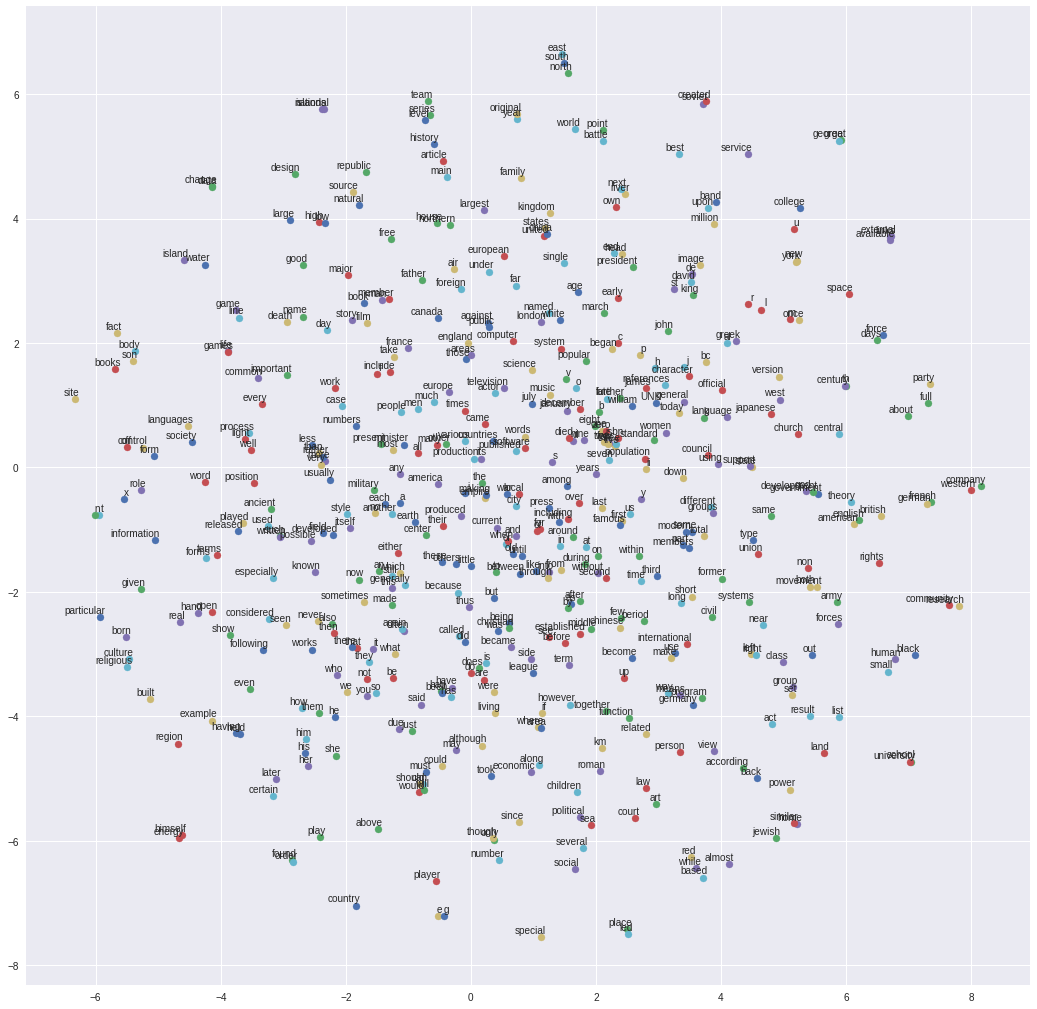

In [125]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

##An Encoder-Decoder Network for Machine Translation
The **basic_rnn_seq2seq()** function creates a simple Encoder/Decoder model: it first runs an RNN to encode encoder_inputs into a state vector, then runs a decoder initialized with the last encoder state on **decoder_inputs**. Encoder and decoder use the same RNN cell type but they don't share parameters.

In [0]:
reset_graph()

n_steps = 50
n_neurons = 200
n_layers = 3
num_encoder_symbols = 20000
num_decoder_symbols = 20000
embedding_size = 150
learning_rate = 0.01

X = tf.placeholder(tf.int32, [None, n_steps]) # English sentences
Y = tf.placeholder(tf.int32, [None, n_steps]) # French translations
W = tf.placeholder(tf.float32, [None, n_steps - 1, 1])
Y_input = Y[:, :-1]
Y_target = Y[:, 1:]

encoder_inputs = tf.unstack(tf.transpose(X)) # list of 1D tensors
decoder_inputs = tf.unstack(tf.transpose(Y_input)) # list of 1D tensors

lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
              for layer in range(n_layers)]
cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

output_seqs, states = tf.contrib.legacy_seq2seq.embedding_rnn_seq2seq(
    encoder_inputs,
    decoder_inputs,
    cell,
    num_encoder_symbols,
    num_decoder_symbols,
    embedding_size)

logits = tf.transpose(tf.unstack(output_seqs), perm=[1, 0, 2])

In [0]:
logits_flat = tf.reshape(logits, [-1, num_decoder_symbols])
Y_target_flat = tf.reshape(Y_target, [-1])
W_flat = tf.reshape(W, [-1])
xentropy = W_flat * tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y_target_flat, logits=logits_flat)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()